In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import preprocessing as prc
import joblib
import numpy as np

In [65]:
scaler  = joblib.load("../models/scaler")
model  = joblib.load("../models/forest.sav")
image = cv2.imread('../photos/4.png')

In [85]:
@timer
def filter_digits(image, threshold):

    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(grey.copy(), threshold, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    thresh_display = thresh.copy()
    color_display = image.copy()
    preprocessed_digits = []

    lines = []
    
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)

        # Box display
        cv2.rectangle(color_display, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
        
        
        digit = thresh[y:y + h, x:x + w]
        
        # Resizing that digit to (18, 18)
        resized_digit = cv2.resize(digit, (18, 18))
        
        # Padding the digit with 5 pixels of (zeros) in each side as in MNIST
        padded_digit = np.pad(resized_digit, ((5, 5), (5, 5)), "constant", constant_values=0)
        
        preprocessed_digits.append((x, y, w, h, padded_digit))
        
    print("Digits: ",len(preprocessed_digits))    
    # finding line splits    
    for x, y, w, h, _ in preprocessed_digits:
        collision = False
        for xl, yl, wl, hl, _ in preprocessed_digits:
            if( y + h < yl + hl and y + h > yl + hl*0.25):
                collision = True
                break
        if (y + h not in lines and collision ==False):
            lines.append(y + h)
                        
    print(f"Lines: {len(lines)}")
    for line in lines:
        cv2.line(color_display,(-5,line),(999999,line),(0,0,255),2)
        
    result = []
    # assigning lines to digits
    for x, y, w, h, digit in preprocessed_digits:
        min_distance = 999999
        min_line = 0
        for index, line in enumerate(lines):
            if (line - (y+h) >= 0) and (line - (y + h) < min_distance):
                min_distance = (line - y)
                min_line = index
        result.append((len(lines) - min_line - 1, x, digit))
            
    result.sort(key=lambda x: (x[0], x[1]))
    
    return color_display, result

In [80]:
color_display, preprocessed_digits = filter_digits(image, 90)

Digits:  6
Lines: 2


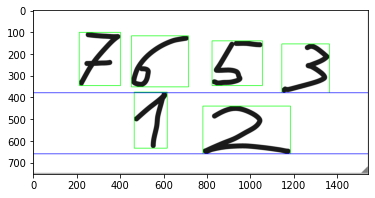

In [81]:
plt.imshow(color_display)
plt.show()

Line: 0, X_pos: 212
Precidition: [[0.03 0.04 0.23 0.27 0.09 0.11 0.02 0.06 0.13 0.02]]
 [3] 



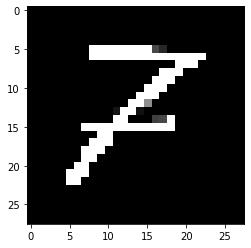

Line: 0, X_pos: 452
Precidition: [[0.28 0.02 0.12 0.02 0.06 0.21 0.12 0.05 0.05 0.07]]
 [0] 



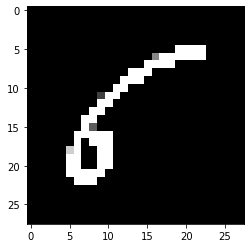

Line: 0, X_pos: 823
Precidition: [[0.11 0.05 0.04 0.08 0.1  0.25 0.16 0.06 0.08 0.07]]
 [5] 



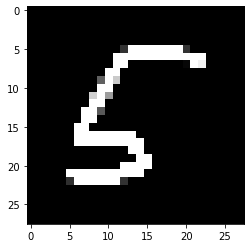

Line: 0, X_pos: 1144
Precidition: [[0.02 0.04 0.14 0.46 0.02 0.13 0.   0.06 0.09 0.04]]
 [3] 



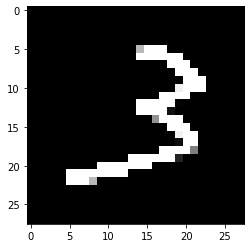

Line: 1, X_pos: 465
Precidition: [[0.   0.01 0.03 0.   0.09 0.02 0.   0.81 0.01 0.03]]
 [7] 



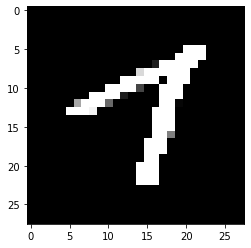

Line: 1, X_pos: 781
Precidition: [[0.03 0.14 0.53 0.07 0.   0.07 0.05 0.05 0.04 0.02]]
 [2] 



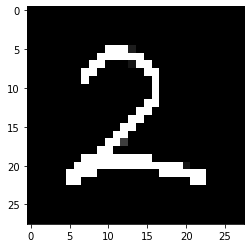

In [82]:
for line, x, digit in preprocessed_digits:
    trs1 = digit.reshape(1, 28, 28, 1)
    trs2 = np.reshape(trs1, (1, 784))
    trs = scaler.transform(trs2)

    print(f"Line: {line}, X_pos: {x}")
    print (f"Precidition: {model.predict_proba(trs)}\n {model.predict(trs)  } \n")
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()

In [90]:
# simple timer decorator
from time import time
def timer(func):
    def wrapper(*args, **kwargs):
        before = time()
        result = func(*args, **kwargs)
        after = time()
        print("Elapsed: ", after - before)
        return result
    return wrapper


@timer
def filter_and_plot(image, threshold, show_greyscale="Vertical"):

    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(grey.copy(), threshold, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    color_display = image.copy()
    preprocessed_digits = []
    
    if(show_greyscale != "None"):
        thresh_display = thresh.copy()

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        
        # Box display
        cv2.rectangle(color_display, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
        
        digit = thresh[y:y + h, x:x + w]
        
        # Resizing that digit to (18, 18)
        resized_digit = cv2.resize(digit, (18, 18))
        
        # Padding the digit with 5 pixels of (zeros) in each side as in MNIST
        padded_digit = np.pad(resized_digit, ((5, 5), (5, 5)), "constant", constant_values=0)
        
        preprocessed_digits.append(padded_digit)

    
    return preprocessed_digits

In [91]:
x = filter_and_plot(image, 90,)

Elapsed:  0.015306234359741211


In [92]:
y = filter_digits(image, 90)

Digits:  6
Lines: 2
Elapsed:  0.0043070316314697266


In [93]:
@timer
def filter_and_plot(image, threshold, show_greyscale="Vertical"):

    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(grey.copy(), threshold, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    color_display = image.copy()
    
    if(show_greyscale != "None"):
        thresh_display = thresh.copy()

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        
        # Box display
        cv2.rectangle(color_display, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)

    if(show_greyscale == "Horizontal"):
        thresh_3_channel = cv2.cvtColor(thresh_display, cv2.COLOR_GRAY2BGR)
        numpy_horizontal = np.hstack((color_display, thresh_3_channel))
        plt.imshow(numpy_horizontal, cmap="gray")
    elif(show_greyscale == "Vertical"):
        thresh_3_channel = cv2.cvtColor(thresh_display, cv2.COLOR_GRAY2BGR)
        numpy_horizontal = np.vstack((color_display, thresh_3_channel))
        plt.imshow(numpy_horizontal, cmap="gray")  
    else:
        plt.imshow(color_display, cmap="gray")    
    
    plt.axis("off")

Elapsed:  0.0500643253326416


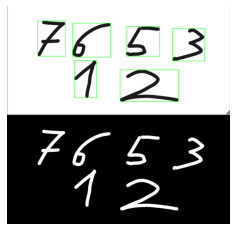

In [94]:
x = filter_and_plot(image, 90,)